<a href="https://colab.research.google.com/github/shreyadata804/model-training-imbalance/blob/iris-dataset/Moderately%20Imbalanced/iris_moderately_imbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import model selection and evaluation tools
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Import preprocessing tools
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Import advanced classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import imbalance handling techniques
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids, NearMiss

In [2]:
from google.colab import files

# Load the uploaded Iris dataset
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Read the CSV file into a DataFrame named 'iris_df'
iris_df = pd.read_csv(file_name)

# Display the first few rows
print(iris_df.head())

Saving iris.csv to iris.csv
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [3]:
# Check dataset characteristics
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
# Checking for missing values
iris_df.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0
species,0


In [5]:
# Check the data types of all columns
print(iris_df.dtypes)

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


In [6]:
# Data type conversion
# Convert 'species' to categorical if not already
iris_df['species'] = iris_df['species'].astype('category')

In [7]:
# Check the data types of all columns
print(iris_df.dtypes)

sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
species         category
dtype: object


In [8]:
print(iris_df['species'].unique())
print(iris_df['species'].dtype)

['setosa', 'versicolor', 'virginica']
Categories (3, object): ['setosa', 'versicolor', 'virginica']
category


In [9]:
iris_df.shape

(150, 5)

In [10]:
# Removing duplicates
iris_df = iris_df.drop_duplicates()

In [11]:
iris_df.shape

(147, 5)

In [12]:
iris_df['species'].value_counts()

,count
species,
versicolor,50
virginica,49
setosa,48


In [13]:
# Filter out the species for each type
setosa = iris_df[iris_df['species'] == 'setosa']
versicolor = iris_df[iris_df['species'] == 'versicolor']
virginica = iris_df[iris_df['species'] == 'virginica']

# Function to generate imbalanced dataset
def generate_imbalanced_data(versicolor_samples, ratio_versicolor, ratio_virginica, ratio_setosa):
    # Calculate total dataset size based on the desired proportion of versicolor
    total_samples = int(versicolor_samples / ratio_versicolor)

    # Calculate how many samples to select from each species
    vir_samples = int(total_samples * ratio_virginica)
    setosa_samples = int(total_samples * ratio_setosa)

    # Sample the datasets
    setosa_imb = setosa.sample(setosa_samples, random_state=42)
    virginica_imb = virginica.sample(vir_samples, random_state=42)

    # Concatenate them into the final imbalanced dataset
    imbalanced_data = pd.concat([setosa_imb, versicolor, virginica_imb])

    return imbalanced_data

# 1. Slightly Imbalanced (50:30:20)
slightly_imbalanced = generate_imbalanced_data(50, 0.5, 0.3, 0.2)

# 2. Moderately Imbalanced (70:20:10)
moderately_imbalanced = generate_imbalanced_data(50, 0.7, 0.2, 0.1)

# 3. Severely Imbalanced (85:10:5)
severely_imbalanced = generate_imbalanced_data(50, 0.85, 0.1, 0.05)

# Check the class distribution in the imbalanced datasets
print("Slightly Imbalanced Class Distribution:")
print(slightly_imbalanced['species'].value_counts())

print("\nModerately Imbalanced Class Distribution:")
print(moderately_imbalanced['species'].value_counts())

print("\nSeverely Imbalanced Class Distribution:")
print(severely_imbalanced['species'].value_counts())

Slightly Imbalanced Class Distribution:
species
versicolor    50
virginica     30
setosa        20
Name: count, dtype: int64

Moderately Imbalanced Class Distribution:
species
versicolor    50
virginica     14
setosa         7
Name: count, dtype: int64

Severely Imbalanced Class Distribution:
species
versicolor    50
virginica      5
setosa         2
Name: count, dtype: int64


In [14]:
moderately_imbalanced.shape

(71, 5)

### Baseline Model

To establish a reference point for model performance, various classification models were applied to the dataset with minimal preprocessing. The preprocessing steps included duplicate removal to maintain data integrity and target encoding to convert categorical labels into numerical values


Evaluating Dummy Classifier with Stratified K-Fold...
Dummy Classifier - Accuracy: 0.6985
Dummy Classifier - Precision: 0.4912
Dummy Classifier - Recall: 0.6985
Dummy Classifier - F1-Score: 0.5759
Evaluating Logistic Regression with Stratified K-Fold...
Logistic Regression - Accuracy: 0.9470
Logistic Regression - Precision: 0.9200
Logistic Regression - Recall: 0.9470
Logistic Regression - F1-Score: 0.9297
Evaluating Random Forest with Stratified K-Fold...
Random Forest - Accuracy: 0.9288
Random Forest - Precision: 0.9511
Random Forest - Recall: 0.9288
Random Forest - F1-Score: 0.9286
Evaluating Decision Tree with Stratified K-Fold...
Decision Tree - Accuracy: 0.9288
Decision Tree - Precision: 0.9511
Decision Tree - Recall: 0.9288
Decision Tree - F1-Score: 0.9286
Evaluating SVM with Stratified K-Fold...
SVM - Accuracy: 0.8576
SVM - Precision: 0.8108
SVM - Recall: 0.8576
SVM - F1-Score: 0.8140
Model Performance Summary:
                     Accuracy  Precision    Recall  F1-Score
Dummy C

<Figure size 1200x600 with 0 Axes>

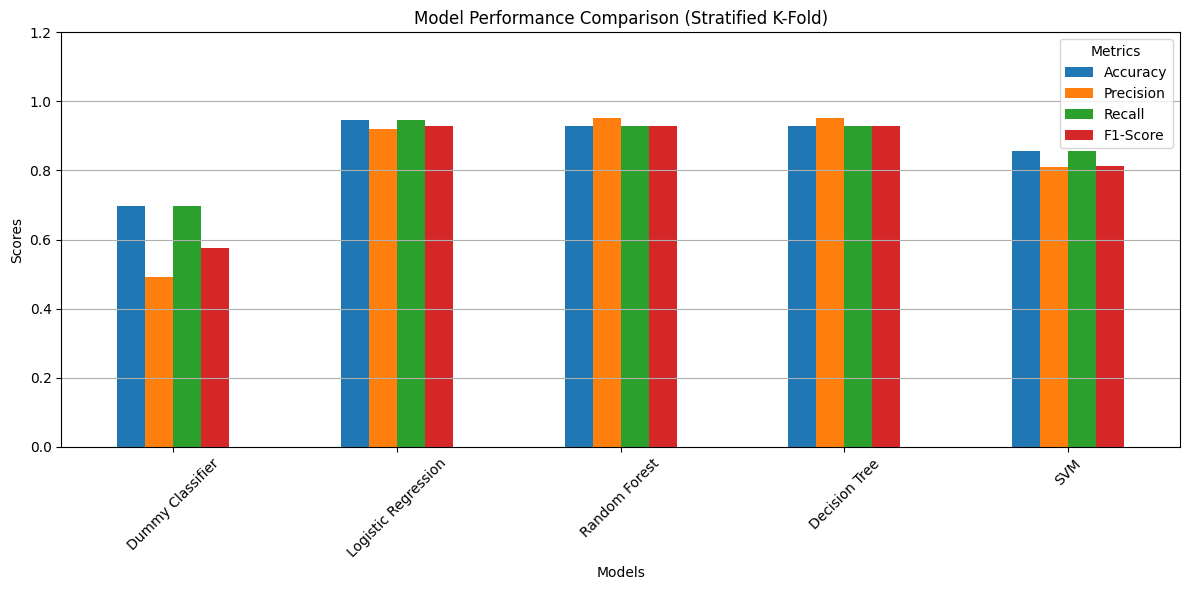

In [15]:
# Define X (features) and y (target variable)
X = moderately_imbalanced.drop(columns=['species'])  # Drop the target column to keep only the features
y = moderately_imbalanced['species']  # Target variable

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)  # Convert species labels to numerical values

# Split the dataset into a training set and hold-out test set (not used in CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics with zero_division fix (No more precision warnings)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
}

# Dictionary to store cross-validation results
cv_results = {}

# Loop through models and perform cross-validation
for name, model in models.items():
    print(f"Evaluating {name} with Stratified K-Fold...")

    # Perform cross-validation (using already scaled X_train_scaled)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

    # Store mean results
    cv_results[name] = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1-Score': np.mean(scores['test_f1']),
    }

    # Print results
    print(f"{name} - Accuracy: {cv_results[name]['Accuracy']:.4f}")
    print(f"{name} - Precision: {cv_results[name]['Precision']:.4f}")
    print(f"{name} - Recall: {cv_results[name]['Recall']:.4f}")
    print(f"{name} - F1-Score: {cv_results[name]['F1-Score']:.4f}")
    print("=" * 50)

# Convert results to DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results).T
print("Model Performance Summary:")
print(cv_results_df)

# Save results to CSV
cv_results_df.to_csv('model_metrics_stratified_kfold.csv', index=True)

# Plot results
plt.figure(figsize=(12, 6))
cv_results_df.plot(kind='bar', figsize=(12, 6))

# Customizing the bar chart
plt.title('Model Performance Comparison (Stratified K-Fold)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1.2)
plt.legend(title='Metrics', loc='best')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**

- The Dummy Classifier (predicts the most frequent class) has an accuracy of 69.8%, meaning that a model must outperform this baseline to be useful.

- Logistic Regression and Random Forest perform well, with >92% accuracy.

- SVM performs the worst (85.8%), likely because it struggles with class imbalance.

### Outlier Handling
Outliers were managed using the Interquartile Range (**IQR**) method, **capping** extreme values within calculated bounds. This was applied to the **original dataset** (iris_df) to prevent data loss in the minority class of the imbalanced dataset. Handling outliers after creating the moderately imbalanced dataset would have increased the number of outliers, potentially leading to further data loss and imbalance.

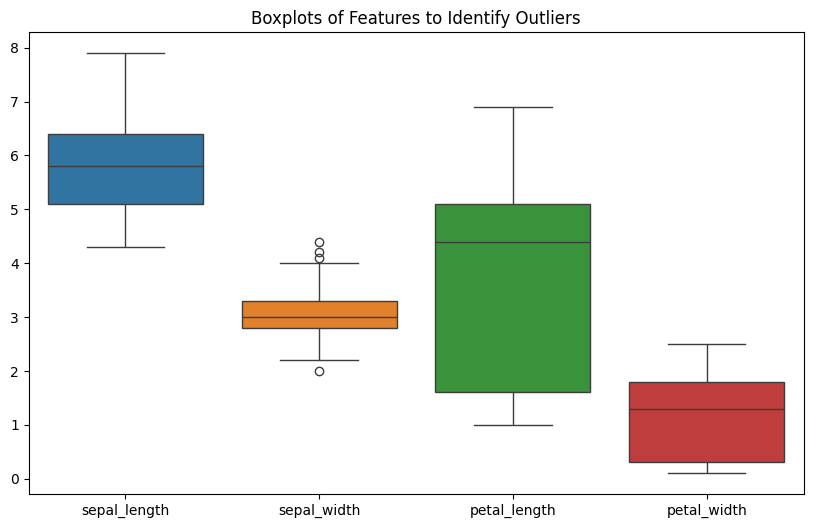

In [16]:
# Plotting box plots for each feature to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
plt.title("Boxplots of Features to Identify Outliers")
plt.show()


In [17]:
#  Handling outliers
# Step 1:Calculate Q1, Q3, and IQR for each feature
Q1 = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].quantile(0.25)
Q3 = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define lower and upper bounds for capping
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify and count outliers
outliers = ((iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] < lower_bound) |
            (iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] > upper_bound))
outliers_count = outliers.sum()
print("Outliers in each column:\n", outliers_count)

# Step 4: Capping values using the calculated lower and upper bounds
iris_df_capped = iris_df.copy()

# Clip each feature in the dataset
for column in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    iris_df_capped[column] = iris_df_capped[column].clip(lower=lower_bound[column], upper=upper_bound[column])

# Display the capped DataFrame
print(iris_df_capped.head())


Outliers in each column:
 sepal_length    0
sepal_width     4
petal_length    0
petal_width     0
dtype: int64
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.110155      0.871305     0.817058
sepal_width      -0.110155     1.000000     -0.420140    -0.355139
petal_length      0.871305    -0.420140      1.000000     0.961883
petal_width       0.817058    -0.355139      0.961883     1.000000


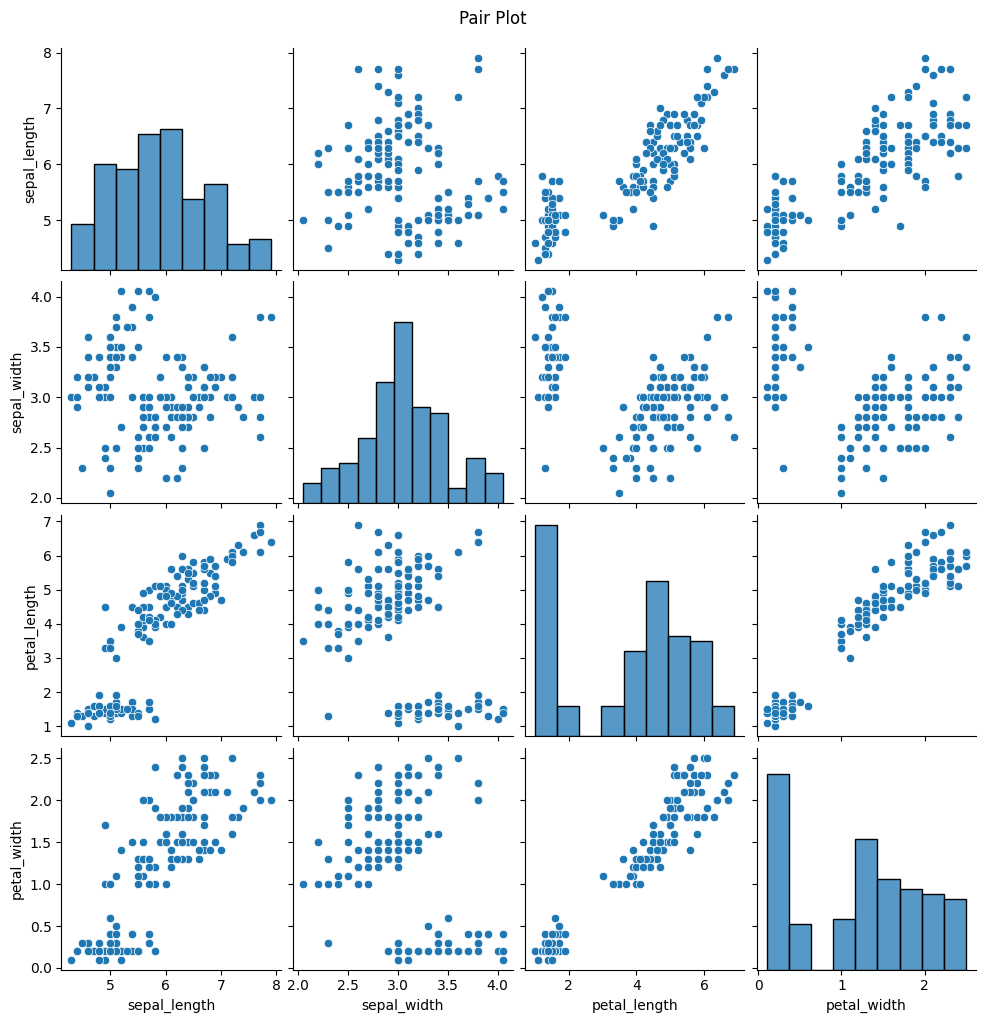

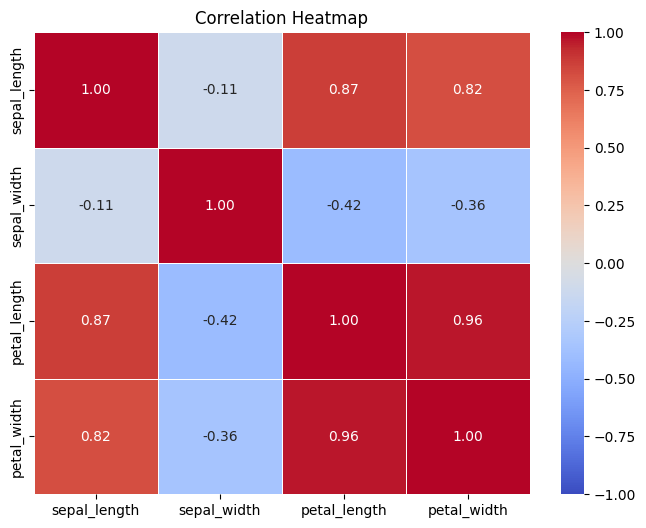

In [18]:
# Exclude non-numeric columns (e.g., species column)
numeric_iris_df = iris_df_capped.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns only
correlation_matrix = numeric_iris_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Pair plot to visualize the relationships between all features
sns.pairplot(iris_df_capped)
plt.suptitle("Pair Plot", y=1.02)
plt.show()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Highly Correlated Pairs (|correlation| > 0.8):

Sepal Length ↔ Petal Length → 0.87

Sepal Length ↔ Petal Width → 0.82

Petal Length ↔ Petal Width → 0.96 (highest correlation)

### Creating Imbalanced Datasets from the Preprocessed Data
Imbalanced datasets were generated again, this time after preprocessing.

In [19]:
# Filter out the species for each type
setosa = iris_df_capped[iris_df_capped['species'] == 'setosa']
versicolor = iris_df_capped[iris_df_capped['species'] == 'versicolor']
virginica = iris_df_capped[iris_df_capped['species'] == 'virginica']

# Function to generate imbalanced dataset
def generate_imbalanced_data(versicolor_samples, ratio_versicolor, ratio_virginica, ratio_setosa):
    # Calculate total dataset size based on the desired proportion of versicolor
    total_samples = int(versicolor_samples / ratio_versicolor)

    # Calculate how many samples to select from each species
    vir_samples = int(total_samples * ratio_virginica)
    setosa_samples = int(total_samples * ratio_setosa)

    # Sample the datasets
    setosa_imb = setosa.sample(setosa_samples, random_state=42)
    virginica_imb = virginica.sample(vir_samples, random_state=42)

    # Concatenate them into the final imbalanced dataset
    imbalanced_data = pd.concat([setosa_imb, versicolor, virginica_imb])

    return imbalanced_data

# 1. Slightly Imbalanced (50:30:20)
slightly_imbalanced= generate_imbalanced_data(50, 0.5, 0.3, 0.2)

# 2. Moderately Imbalanced (70:20:10)
moderately_imbalanced= generate_imbalanced_data(50, 0.7, 0.2, 0.1)

# 3. Severely Imbalanced (85:10:5)
severely_imbalanced= generate_imbalanced_data(50, 0.85, 0.1, 0.05)

# Check the class distribution in the imbalanced datasets
print("Slightly Imbalanced Class Distribution:")
print(slightly_imbalanced['species'].value_counts())

print("\nModerately Imbalanced Class Distribution:")
print(moderately_imbalanced['species'].value_counts())

print("\nSeverely Imbalanced Class Distribution:")
print(severely_imbalanced['species'].value_counts())

Slightly Imbalanced Class Distribution:
species
versicolor    50
virginica     30
setosa        20
Name: count, dtype: int64

Moderately Imbalanced Class Distribution:
species
versicolor    50
virginica     14
setosa         7
Name: count, dtype: int64

Severely Imbalanced Class Distribution:
species
versicolor    50
virginica      5
setosa         2
Name: count, dtype: int64


In [20]:
moderately_imbalanced.head()

,sepal_length,sepal_width,petal_length,petal_width,species
27,5.2,3.5,1.5,0.2,setosa
42,4.4,3.2,1.3,0.2,setosa
26,5.0,3.4,1.6,0.4,setosa
45,4.8,3.0,1.4,0.3,setosa
24,4.8,3.4,1.9,0.2,setosa


### Evaluating base Models Performance

Evaluating Dummy Classifier with Stratified K-Fold...
Dummy Classifier - Accuracy: 0.6985
Dummy Classifier - Precision: 0.4912
Dummy Classifier - Recall: 0.6985
Dummy Classifier - F1-Score: 0.5759
Evaluating Logistic Regression with Stratified K-Fold...
Logistic Regression - Accuracy: 0.9470
Logistic Regression - Precision: 0.9531
Logistic Regression - Recall: 0.9470
Logistic Regression - F1-Score: 0.9409
Evaluating Random Forest with Stratified K-Fold...
Random Forest - Accuracy: 0.9470
Random Forest - Precision: 0.9672
Random Forest - Recall: 0.9470
Random Forest - F1-Score: 0.9493
Evaluating Decision Tree with Stratified K-Fold...
Decision Tree - Accuracy: 0.9470
Decision Tree - Precision: 0.9672
Decision Tree - Recall: 0.9470
Decision Tree - F1-Score: 0.9493
Evaluating SVM with Stratified K-Fold...
SVM - Accuracy: 0.9636
SVM - Precision: 0.9677
SVM - Recall: 0.9636
SVM - F1-Score: 0.9586
Model Performance Summary:
                     Accuracy  Precision    Recall  F1-Score
Dummy C

<Figure size 1200x600 with 0 Axes>

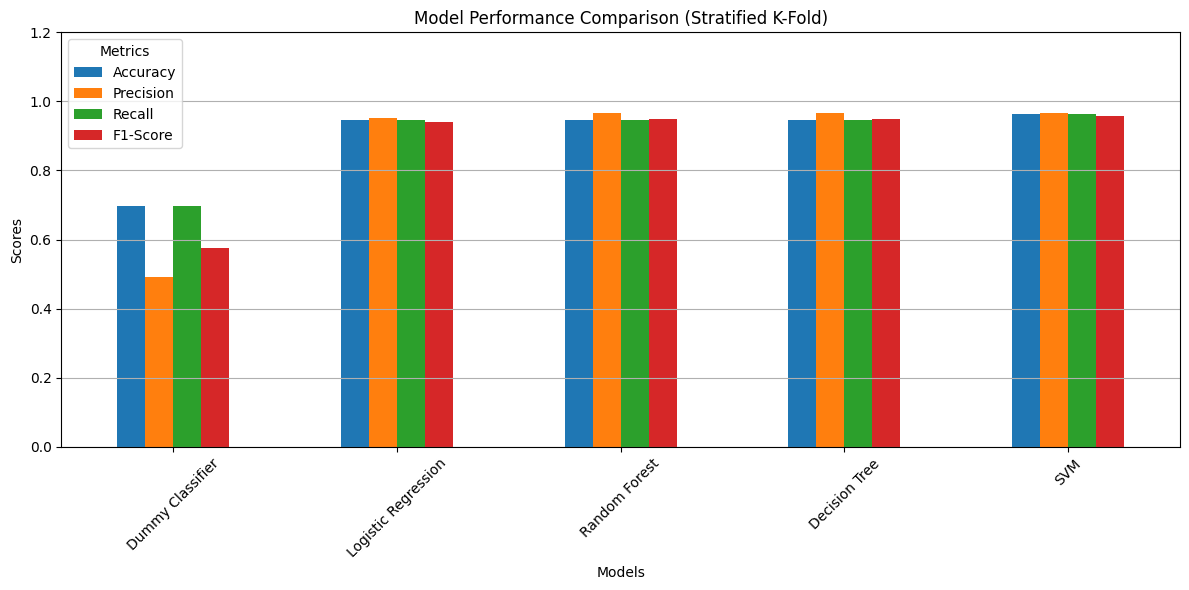

In [21]:
# Define X (features) and y (target variable)
X = moderately_imbalanced.drop(columns=['species'])  # Drop the target column to keep only the features
y = moderately_imbalanced['species']  # Target variable

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)  # Convert species labels to numerical values

# Split the dataset into a training set and hold-out test set (not used in CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply StandardScaler only on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform only on training data
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

# Define models (WITHOUT scaling inside cross-validation)
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics with zero_division fix (No more precision warnings)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
}

# Dictionary to store cross-validation results
cv_results = {}

# Loop through models and perform cross-validation
for name, model in models.items():
    print(f"Evaluating {name} with Stratified K-Fold...")

    # Perform cross-validation (using already scaled X_train_scaled)
    scores = cross_validate(model, X_train_scaled, y_train, cv=skf, scoring=scoring, return_train_score=False)

    # Store mean results
    cv_results[name] = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1-Score': np.mean(scores['test_f1']),
    }

    # Print results
    print(f"{name} - Accuracy: {cv_results[name]['Accuracy']:.4f}")
    print(f"{name} - Precision: {cv_results[name]['Precision']:.4f}")
    print(f"{name} - Recall: {cv_results[name]['Recall']:.4f}")
    print(f"{name} - F1-Score: {cv_results[name]['F1-Score']:.4f}")
    print("=" * 50)

# Convert results to DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results).T
print("Model Performance Summary:")
print(cv_results_df)

# Save results to CSV
cv_results_df.to_csv('model_metrics_stratified_kfold.csv', index=True)

# Plot results
plt.figure(figsize=(12, 6))
cv_results_df.plot(kind='bar', figsize=(12, 6))

# Customizing the bar chart
plt.title('Model Performance Comparison (Stratified K-Fold)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1.2)
plt.legend(title='Metrics', loc='best')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feature Importance Base Models

Feature Importance for All Models:
              Random Forest  Decision Tree  Logistic Regression       SVM
Feature                                                                  
petal_length       0.457090       0.870001             1.054327  0.802465
petal_width        0.386825       0.053181             1.083421  0.625836
sepal_width        0.090738       0.076818             0.590312  0.333581
sepal_length       0.065346       0.000000             0.424389  0.179420


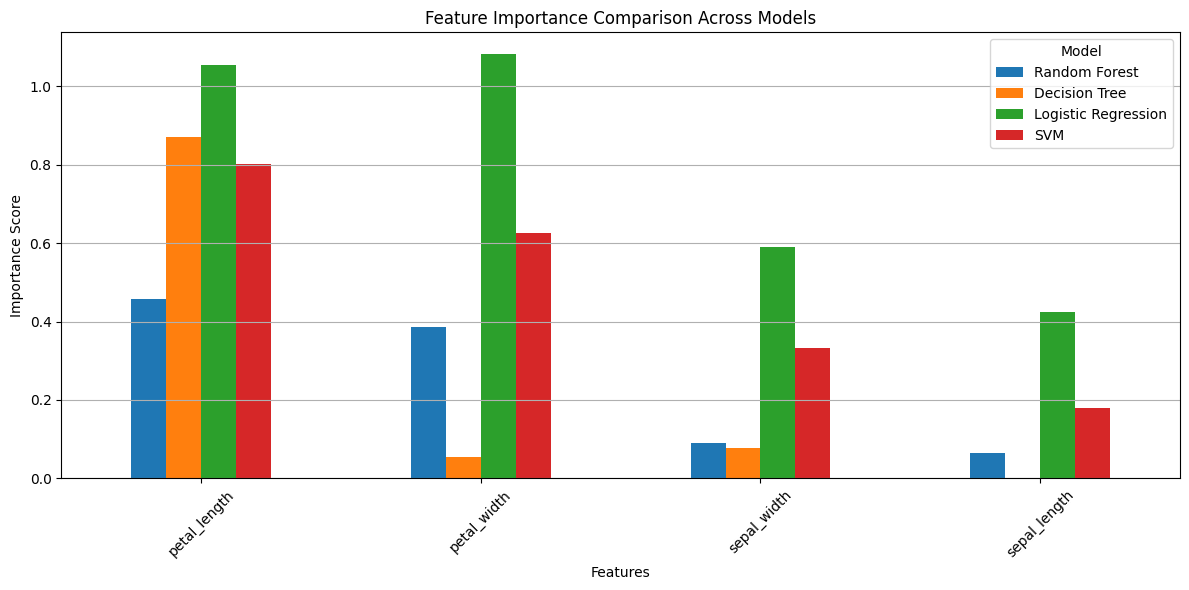

In [22]:
# Train Tree-Based Models on Unscaled Data
rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)  # Use original features (not scaled)
dt.fit(X_train, y_train)  # Use original features (not scaled)

# Train Logistic Regression & SVM on Scaled Data
lr = LogisticRegression(max_iter=200)
svm = SVC(kernel='linear')

lr.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)

# Get Feature Importance Scores
rf_importance = rf.feature_importances_
dt_importance = dt.feature_importances_
lr_importance = np.mean(np.abs(lr.coef_), axis=0)  # Mean absolute value for multi-class
svm_importance = np.mean(np.abs(svm.coef_), axis=0)  # Mean absolute value for multi-class

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': rf_importance,
    'Decision Tree': dt_importance,
    'Logistic Regression': lr_importance,
    'SVM': svm_importance
}).set_index('Feature')

# **Sort by Feature Importance (Random Forest)**
feature_importance_df = feature_importance_df.sort_values(by="Random Forest", ascending=False)

# Display Feature Importance
print("Feature Importance for All Models:")
print(feature_importance_df)

# Plot Feature Importance
feature_importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [23]:
moderately_imbalanced_df= moderately_imbalanced.copy()

In [24]:
!pip install dask[dataframe]

In [25]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


### Expanding Model Evaluation Beyond Baseline Models

Evaluating Dummy Classifier with Stratified K-Fold...
Dummy Classifier - Accuracy: 0.6985
Dummy Classifier - Precision: 0.4912
Dummy Classifier - Recall: 0.6985
Dummy Classifier - F1-Score: 0.5759
Evaluating Logistic Regression with Stratified K-Fold...
Logistic Regression - Accuracy: 0.9470
Logistic Regression - Precision: 0.9531
Logistic Regression - Recall: 0.9470
Logistic Regression - F1-Score: 0.9409
Evaluating Decision Tree with Stratified K-Fold...
Decision Tree - Accuracy: 0.9470
Decision Tree - Precision: 0.9672
Decision Tree - Recall: 0.9470
Decision Tree - F1-Score: 0.9493
Evaluating Random Forest with Stratified K-Fold...
Random Forest - Accuracy: 0.9470
Random Forest - Precision: 0.9672
Random Forest - Recall: 0.9470
Random Forest - F1-Score: 0.9493
Evaluating SVM with Stratified K-Fold...
SVM - Accuracy: 0.9636
SVM - Precision: 0.9677
SVM - Recall: 0.9636
SVM - F1-Score: 0.9586
Evaluating KNN with Stratified K-Fold...
KNN - Accuracy: 0.9636
KNN - Precision: 0.9677
KNN - R

<Figure size 1200x600 with 0 Axes>

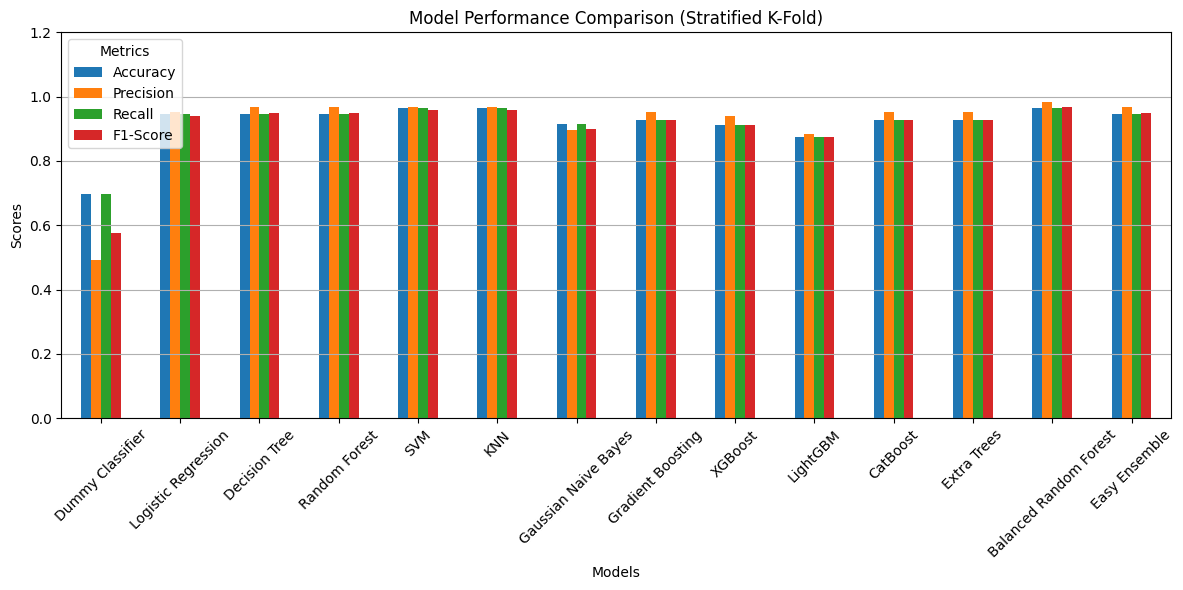

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Prepare features (X) and target variable (y)
X = moderately_imbalanced_df.drop(columns=['species'])  # Features
y = moderately_imbalanced_df['species']  # Target variable

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)  # Convert species labels to numerical values

# Split the dataset into training and hold-out test sets (not used in CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply StandardScaler only on the training set (Avoiding data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

# Define models
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric="mlogloss", random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42),
    'Easy Ensemble': EasyEnsembleClassifier(random_state=42),
    # 'RUSBoost': RUSBoostClassifier(random_state=42)
}
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics with zero_division fix (No more precision warnings)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
}

# Dictionary to store cross-validation results
cv_results = {}

# Loop through models and perform cross-validation
for name, model in models.items():
    print(f"Evaluating {name} with Stratified K-Fold...")

    # Perform cross-validation (using already scaled X_train_scaled)
    scores = cross_validate(model, X_train_scaled, y_train, cv=skf, scoring=scoring, return_train_score=False)

    # Store mean results
    cv_results[name] = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1-Score': np.mean(scores['test_f1']),
    }

    # Print results
    print(f"{name} - Accuracy: {cv_results[name]['Accuracy']:.4f}")
    print(f"{name} - Precision: {cv_results[name]['Precision']:.4f}")
    print(f"{name} - Recall: {cv_results[name]['Recall']:.4f}")
    print(f"{name} - F1-Score: {cv_results[name]['F1-Score']:.4f}")
    print("=" * 50)

# Convert results to DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results).T
print("Model Performance Summary:")
print(cv_results_df)

# Save results to CSV
cv_results_df.to_csv('model_metrics_stratified_kfold.csv', index=True)

# Plot results
plt.figure(figsize=(12, 6))
cv_results_df.plot(kind='bar', figsize=(12, 6))

# Customizing the bar chart
plt.title('Model Performance Comparison (Stratified K-Fold)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1.2)
plt.legend(title='Metrics', loc='best')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sorte Model Performance Summary Based on Accuracy

In [27]:
# Convert results into a structured DataFrame
cv_results_list = []  # Use cv_results_list to append rows

# Loop through models' results
for model_name, metrics in cv_results.items():
    row = {
        "Model": model_name,
        "Accuracy": metrics["Accuracy"],  # Correct key
        "F1-Score": metrics["F1-Score"],  # Correct key
        "Precision": metrics["Precision"],  # Correct key
        "Recall": metrics["Recall"]  # Correct key
    }
    cv_results_list.append(row)

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results_list)

# Sort the DataFrame by Accuracy in descending order
cv_results_df = cv_results_df.sort_values(by="Accuracy", ascending=False)

# Display the cleaned DataFrame
from IPython.display import display
display(cv_results_df)

,Model,Accuracy,F1-Score,Precision,Recall
4,SVM,0.963636,0.958645,0.967677,0.963636
5,KNN,0.963636,0.958645,0.967677,0.963636
12,Balanced Random Forest,0.963636,0.967100,0.981818,0.963636
1,Logistic Regression,0.946970,0.940867,0.953093,0.946970
2,Decision Tree,0.946970,0.949322,0.967235,0.946970
3,Random Forest,0.946970,0.949322,0.967235,0.946970
13,Easy Ensemble,0.946970,0.949322,0.967235,0.946970
7,Gradient Boosting,0.928788,0.928644,0.951073,0.928788
10,CatBoost,0.928788,0.928644,0.951073,0.928788
11,Extra Trees,0.928788,0.928644,0.951073,0.928788


### Comparing Model Performance: F1-Score and Accuracy Visualization

                     Model  Accuracy  F1-Score  Precision    Recall
4                      SVM  0.963636  0.958645   0.967677  0.963636
5                      KNN  0.963636  0.958645   0.967677  0.963636
12  Balanced Random Forest  0.963636  0.967100   0.981818  0.963636
1      Logistic Regression  0.946970  0.940867   0.953093  0.946970
2            Decision Tree  0.946970  0.949322   0.967235  0.946970


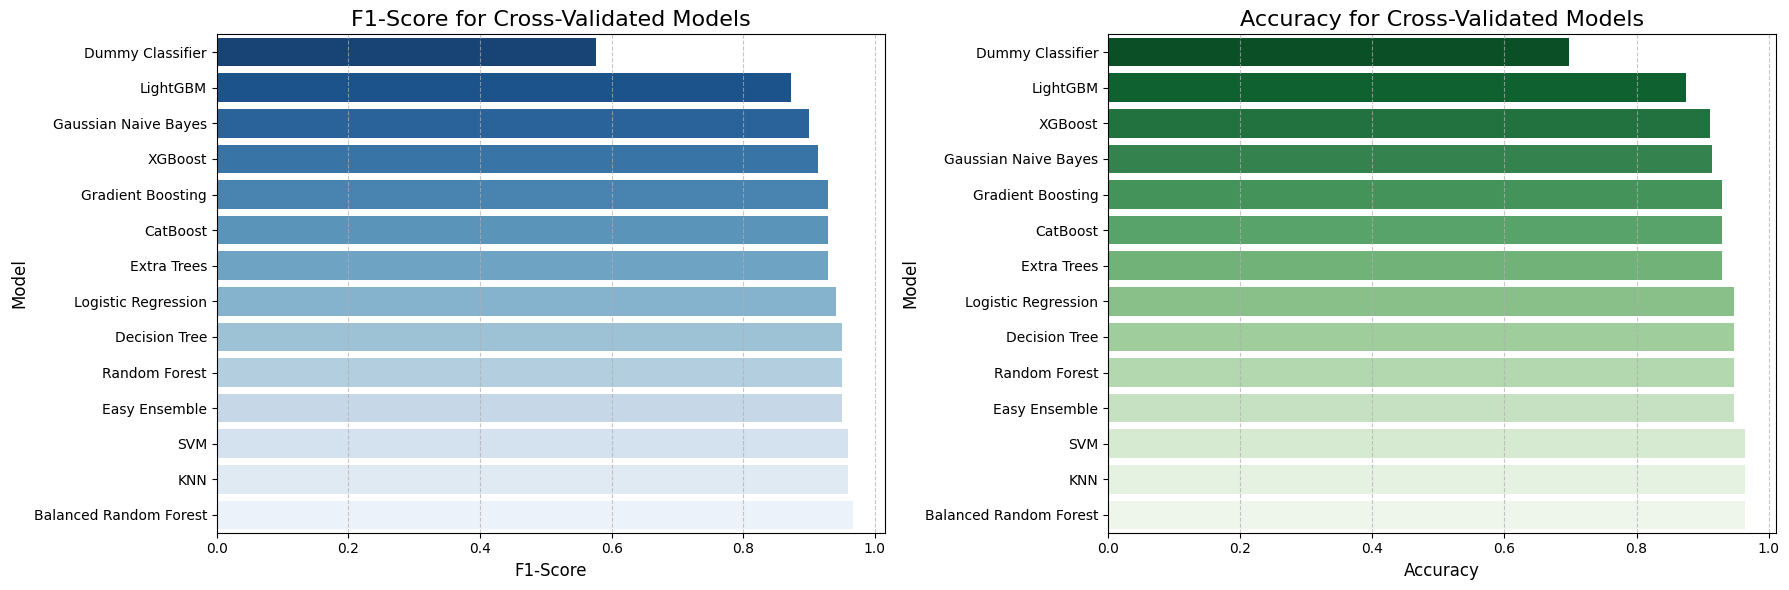

In [28]:
# Ensure the DataFrame exists and has the correct columns
print(cv_results_df.head())  # Debugging step

# Sort models by F1-Score before plotting
cv_results_df = cv_results_df.sort_values(by="F1-Score", ascending=True)

# Create subplots for F1-Score and Accuracy comparisons
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1-Score Bar Plot (Fix FutureWarning: Assign hue or set legend=False)
sns.barplot(x='F1-Score', y='Model', data=cv_results_df, hue='Model', palette="Blues_r", ax=axes[0], legend=False)
axes[0].set_title("F1-Score for Cross-Validated Models", fontsize=16)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_ylabel('Model', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Sort models by Accuracy before plotting
cv_results_df = cv_results_df.sort_values(by="Accuracy", ascending=True)

# Accuracy Bar Plot (Fix FutureWarning)
sns.barplot(x='Accuracy', y='Model', data=cv_results_df, hue='Model', palette="Greens_r", ax=axes[1], legend=False)
axes[1].set_title("Accuracy for Cross-Validated Models", fontsize=16)
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_ylabel('Model', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Evaluating the Impact of Data Balancing Techniques on Model Performance

In [29]:
# Set k_neighbors for SMOTE and Borderline-SMOTE
neighbors = 3

# Define imbalance techniques to test
imbalance_methods = {
    "Original Data": None,
    f"SMOTE (k_neighbors={neighbors})": SMOTE(random_state=42, k_neighbors=neighbors),
    f"Random Oversampling": RandomOverSampler(random_state=42),
    f"Borderline-SMOTE (k_neighbors={neighbors})": BorderlineSMOTE(random_state=42, k_neighbors=neighbors),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
    "Cluster Centroids": ClusterCentroids(random_state=42),
    "NearMiss": NearMiss(version=1)
}

# Prepare features (X) and target variable (y)
X = moderately_imbalanced_df.drop(columns=['species'])  # Features
y = moderately_imbalanced_df['species']  # Target variable

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)  # Convert species labels to numerical values

# Split the dataset into training and hold-out test sets (not used in CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Dictionary to store results for different imbalance techniques
imbalance_results = {}

# Apply each imbalance method separately
for method_name, sampler in imbalance_methods.items():
    print(f"\n==== Evaluating with {method_name} ====\n")

    # Apply sampling technique (if not None)
    if sampler:
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train  # Use original data

    # Apply StandardScaler after resampling (Avoids data leakage)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)  # Fit & transform on resampled data
    X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

    # Define models (WITHOUT scaling inside cross-validation)
    models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric="mlogloss", random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42),
    'Easy Ensemble': EasyEnsembleClassifier(random_state=42),
    # 'RUSBoost': RUSBoostClassifier(random_state=42)
}
    # Define Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define scoring metrics with zero_division fix (No more precision warnings)
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    }

    # Dictionary to store cross-validation results
    cv_results = {}

    # Loop through models and perform cross-validation
    for name, model in models.items():
        print(f"Evaluating {name} with Stratified K-Fold...")

        # Perform cross-validation (using already scaled X_train_scaled)
        scores = cross_validate(model, X_train_scaled, y_train_resampled, cv=skf, scoring=scoring, return_train_score=False)

        # Store mean results
        cv_results[name] = {
            'Accuracy': np.mean(scores['test_accuracy']),
            'Precision': np.mean(scores['test_precision']),
            'Recall': np.mean(scores['test_recall']),
            'F1-Score': np.mean(scores['test_f1']),
        }

        # Print results
        print(f"{name} - Accuracy: {cv_results[name]['Accuracy']:.4f}")
        print(f"{name} - Precision: {cv_results[name]['Precision']:.4f}")
        print(f"{name} - Recall: {cv_results[name]['Recall']:.4f}")
        print(f"{name} - F1-Score: {cv_results[name]['F1-Score']:.4f}")
        print("=" * 50)

    # Store results for this imbalance method
    imbalance_results[method_name] = cv_results

# Save all results into a dictionary
all_results_df = {method: pd.DataFrame(results).T for method, results in imbalance_results.items()}

# Display results
for method, df in all_results_df.items():
    print(f"\n=== Results for {method} ===")
    print(df)
    df.to_csv(f'model_metrics_{method.replace(" ", "_").lower()}.csv', index=True)


==== Evaluating with Original Data ====

Evaluating Dummy Classifier with Stratified K-Fold...
Dummy Classifier - Accuracy: 0.6985
Dummy Classifier - Precision: 0.4912
Dummy Classifier - Recall: 0.6985
Dummy Classifier - F1-Score: 0.5759
Evaluating Logistic Regression with Stratified K-Fold...
Logistic Regression - Accuracy: 0.9470
Logistic Regression - Precision: 0.9531
Logistic Regression - Recall: 0.9470
Logistic Regression - F1-Score: 0.9409
Evaluating Decision Tree with Stratified K-Fold...
Decision Tree - Accuracy: 0.9470
Decision Tree - Precision: 0.9672
Decision Tree - Recall: 0.9470
Decision Tree - F1-Score: 0.9493
Evaluating Random Forest with Stratified K-Fold...
Random Forest - Accuracy: 0.9470
Random Forest - Precision: 0.9672
Random Forest - Recall: 0.9470
Random Forest - F1-Score: 0.9493
Evaluating SVM with Stratified K-Fold...
SVM - Accuracy: 0.9636
SVM - Precision: 0.9677
SVM - Recall: 0.9636
SVM - F1-Score: 0.9586
Evaluating KNN with Stratified K-Fold...
KNN - Accura

### Comparing Model Performance Across Different Resampling Techniques

In [30]:
# Increase the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust width

# Convert results into a structured DataFrame
results_list = []

# Loop through stored results from different imbalance techniques and models
for resampling_method, model_results in imbalance_results.items():
    for model_name, metrics in model_results.items():

        # Ensure that the classification report is correctly formatted
        f1_score = metrics.get("F1-Score", None)
        precision = metrics.get("Precision", None)
        recall = metrics.get("Recall", None)
        accuracy = metrics.get("Accuracy", None)

        # Store results in structured format
        row = {
            "Resampling Method": resampling_method,
            "Model": model_name,
            "Accuracy": accuracy,
            "F1-Score": f1_score,
            "Precision": precision,
            "Recall": recall
        }
        results_list.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Display the cleaned DataFrame
from IPython.display import display
display(results_df)

# Save the structured results for future analysis
results_df.to_csv('resampling_model_performance.csv', index=False)


,Resampling Method,Model,Accuracy,F1-Score,Precision,Recall
0,Original Data,Dummy Classifier,0.698485,0.575917,0.491196,0.698485
1,Original Data,Logistic Regression,0.946970,0.940867,0.953093,0.946970
2,Original Data,Decision Tree,0.946970,0.949322,0.967235,0.946970
3,Original Data,Random Forest,0.946970,0.949322,0.967235,0.946970
4,Original Data,SVM,0.963636,0.958645,0.967677,0.963636
5,Original Data,KNN,0.963636,0.958645,0.967677,0.963636
6,Original Data,Gaussian Naive Bayes,0.913636,0.899715,0.895303,0.913636
7,Original Data,Gradient Boosting,0.928788,0.928644,0.951073,0.928788
8,Original Data,XGBoost,0.910606,0.912958,0.939962,0.910606
9,Original Data,LightGBM,0.874242,0.873060,0.885272,0.874242


In [31]:
# Increase the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust width

# Convert results into a structured DataFrame
results_list = []

# Loop through stored results from different imbalance techniques and models
for resampling_method, model_results in imbalance_results.items():
    for model_name, metrics in model_results.items():

        # Ensure that the classification report is correctly formatted
        f1_score = metrics.get("F1-Score", None)
        precision = metrics.get("Precision", None)
        recall = metrics.get("Recall", None)
        accuracy = metrics.get("Accuracy", None)

        # Store results in structured format
        row = {
            "Resampling Method": resampling_method,
            "Model": model_name,
            "Accuracy": accuracy,
            "F1-Score": f1_score,
            "Precision": precision,
            "Recall": recall
        }
        results_list.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Sort results by Accuracy, then F1-Score (both in descending order)
results_df = results_df.sort_values(by=["Accuracy", "F1-Score"], ascending=[False, False])

# Reset index for better readability
results_df.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
from IPython.display import display
display(results_df)

# Save the structured results for future analysis
results_df.to_csv('resampling_model_performance.csv', index=False)


,Resampling Method,Model,Accuracy,F1-Score,Precision,Recall
0,Cluster Centroids,CatBoost,1.000000,1.000000,1.000000,1.000000
1,Cluster Centroids,Balanced Random Forest,1.000000,1.000000,1.000000,1.000000
2,NearMiss,SVM,1.000000,1.000000,1.000000,1.000000
3,NearMiss,KNN,1.000000,1.000000,1.000000,1.000000
4,NearMiss,Extra Trees,1.000000,1.000000,1.000000,1.000000
5,Random Oversampling,Extra Trees,0.991667,0.991634,0.992593,0.991667
6,Random Oversampling,Easy Ensemble,0.991304,0.991304,0.992391,0.991304
7,SMOTE (k_neighbors=3),Logistic Regression,0.982971,0.982938,0.984984,0.982971
8,SMOTE (k_neighbors=3),Random Forest,0.982971,0.982938,0.984984,0.982971
9,SMOTE (k_neighbors=3),SVM,0.982971,0.982938,0.984984,0.982971


### Model Performance Comparison Across Resampling Techniques: Accuracy and F1-Score Visualization

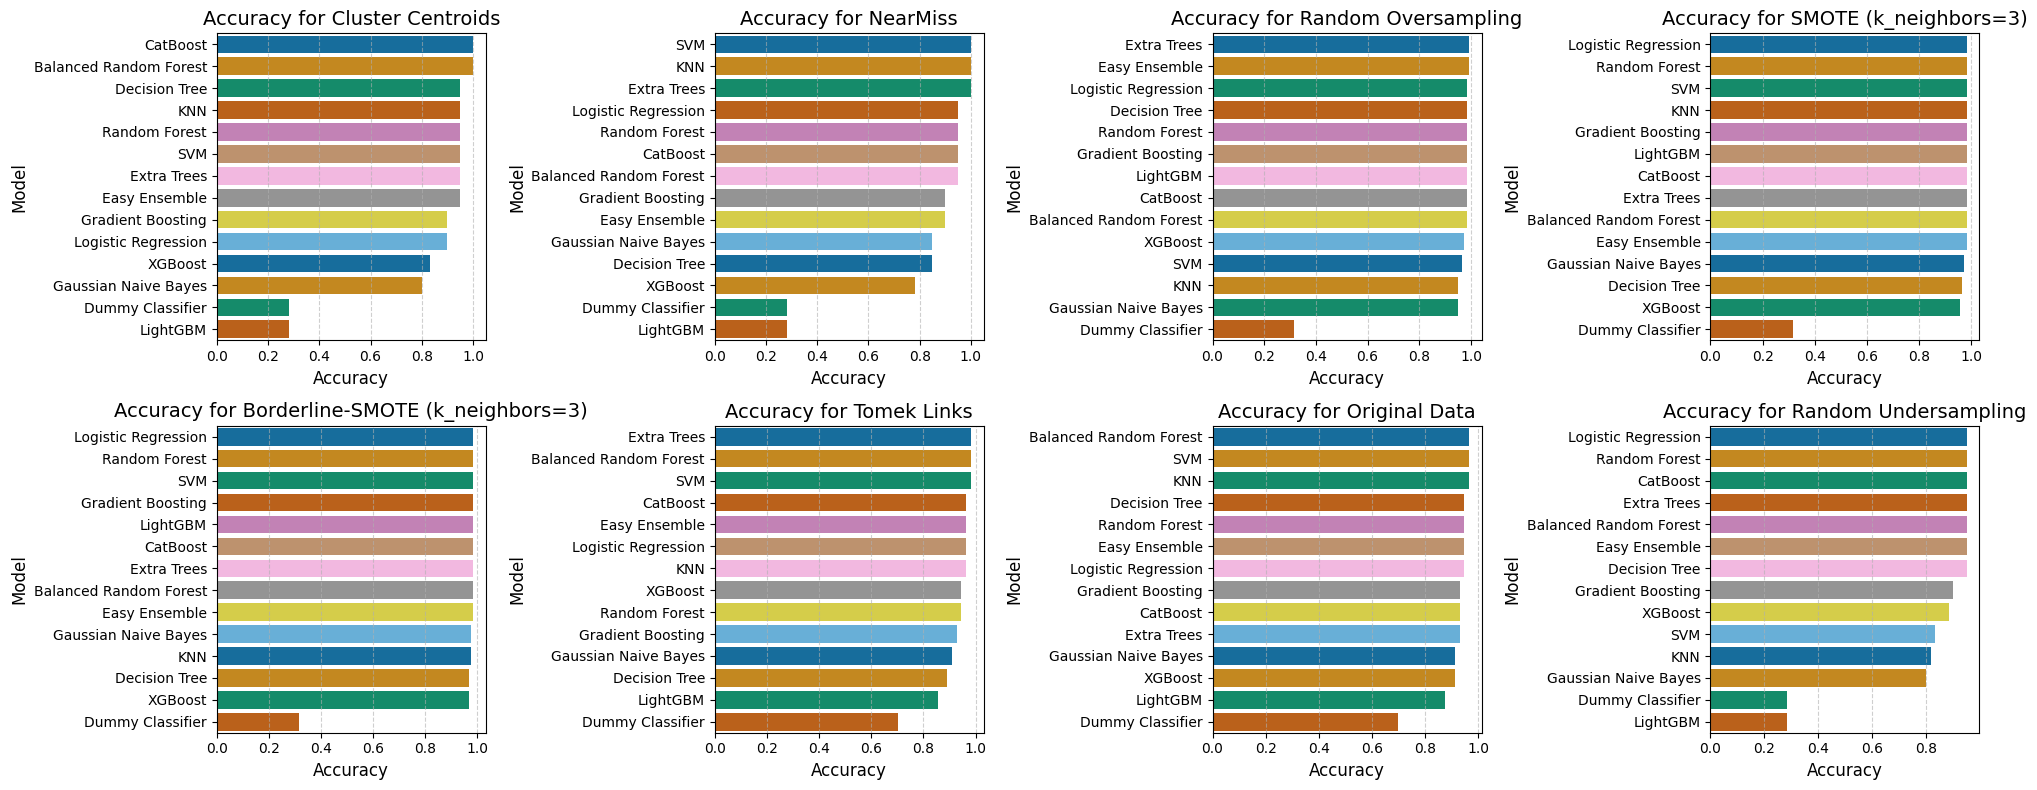

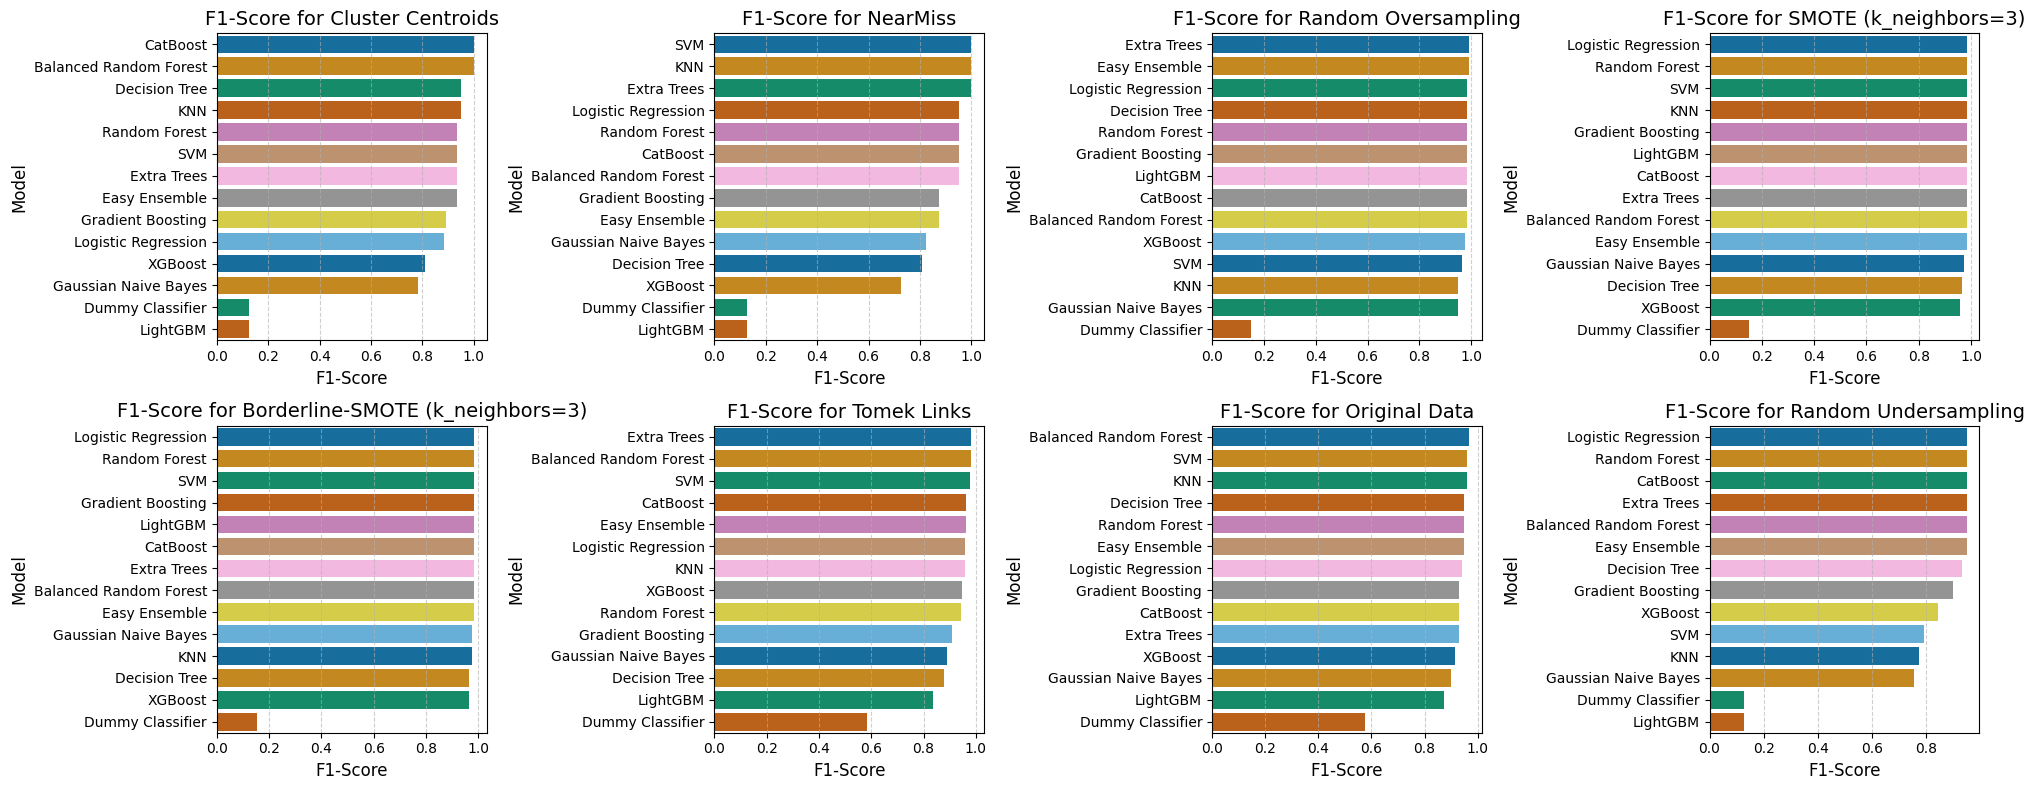

In [32]:
# Extract unique resampling methods from results
resampling_methods = results_df['Resampling Method'].unique()

# Define subplot grid size dynamically
num_methods = len(resampling_methods)  # Number of resampling methods
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_methods + num_cols - 1) // num_cols  # Compute required rows dynamically

# Create figure and subplots for Accuracy plots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot Accuracy for each resampling method
for ax, method in zip(axes, resampling_methods):
    # Filter data for the specific resampling method
    method_data = results_df[results_df['Resampling Method'] == method]

    if method_data.empty:  # Check if method_data has any entries
        ax.set_visible(False)  # Hide empty subplots
        continue  # Skip to the next method

    # Sort models by Accuracy for better visualization
    method_data = method_data.sort_values(by="Accuracy", ascending=False)

    # Create the Accuracy barplot
    sns.barplot(x='Accuracy', y='Model', data=method_data, ax=ax, palette="colorblind")

    # Set title and labels
    ax.set_title(f"Accuracy for {method}", fontsize=14)
    ax.set_xlabel("Accuracy", fontsize=12)
    ax.set_ylabel("Model", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.6)  # Add a subtle grid for readability

# Hide any unused subplots
for i in range(len(resampling_methods), len(axes)):
    axes[i].set_visible(False)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the Accuracy plots first
plt.show()

# --- F1-SCORE PLOTS ---

# Create figure and subplots for F1-Score plots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot F1-Score for each resampling method
for ax, method in zip(axes, resampling_methods):
    # Filter data for the specific resampling method
    method_data = results_df[results_df['Resampling Method'] == method]

    if method_data.empty:  # Check if method_data has any entries
        ax.set_visible(False)  # Hide empty subplots
        continue  # Skip to the next method

    # Sort models by F1-Score for better visualization
    method_data = method_data.sort_values(by="F1-Score", ascending=False)

    # Create the F1-Score barplot
    sns.barplot(x='F1-Score', y='Model', data=method_data, ax=ax, palette="colorblind")

    # Set title and labels
    ax.set_title(f"F1-Score for {method}", fontsize=14)
    ax.set_xlabel("F1-Score", fontsize=12)
    ax.set_ylabel("Model", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.6)  # Add a subtle grid for readability

# Hide any unused subplots
for i in range(len(resampling_methods), len(axes)):
    axes[i].set_visible(False)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the F1-Score plots
plt.show()